<a href="https://colab.research.google.com/github/valeman/Titanic_survival/blob/main/Titanic_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

In [ ]:
!pip install dtype-diet
# Install LAMA as per instructions -> https://github.com/sberbank-ai-lab/LightAutoML

!pip install -U lightautoml
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import math, pprint, joblib

import category_encoders as ce

from timeit import timeit
from time import time

# https://noklam.github.io/dtype_diet/

from dtype_diet import report_on_dataframe, optimize_dtypes

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, train_test_split

import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
try: 
    data_train = pd.read_csv('https://raw.githubusercontent.com/valeman/Titanic_survival/main/train.csv')
    data_test = pd.read_csv('https://raw.githubusercontent.com/valeman/Titanic_survival/main/test.csv')
except:
    print('Data loading error!')

In [ ]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
proposed_df_train = report_on_dataframe(data_train, unit="MB")
df_train = optimize_dtypes(data_train, proposed_df_train)
print('Original dataframe memory: {:.2f} MB'.format(data_train.memory_usage(deep=True).sum()/1024/1024))
print('Proposed dataframe memory: {:.2f} MB'.format(df_train.memory_usage(deep=True).sum()/1024/1024))

Original dataframe memory: 0.31 MB
Proposed dataframe memory: 0.16 MB


In [ ]:
proposed_df_train

,Current dtype,Proposed dtype,Current Memory (MB),Proposed Memory (MB),Ram Usage Improvement (MB),Ram Usage Improvement (%)
Column,,,,,,
PassengerId,int64,int16,3.542969,0.932617,2.610352,73.676957
Survived,int64,int8,3.542969,0.497559,3.045410,85.956450
Pclass,int64,int8,3.542969,0.497559,3.045410,85.956450
Name,object,None,36.592285,NaN,NaN,NaN
Sex,object,category,26.907715,0.597168,26.310547,97.780681
Age,float64,None,3.542969,NaN,NaN,NaN
SibSp,int64,int8,3.542969,0.497559,3.045410,85.956450
Parch,int64,int8,3.542969,0.497559,3.045410,85.956450
Ticket,object,None,27.797852,NaN,NaN,NaN


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    int8    
 2   Pclass       891 non-null    int8    
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int8    
 7   Parch        891 non-null    int8    
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int16(1), int8(4), object(2)
memory usage: 43.0+ KB


In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
proposed_df_test = report_on_dataframe(data_test, unit="MB")
df_test = optimize_dtypes(data_test, proposed_df_test)
print('Original dataframe memory: {:.2f} MB'.format(data_test.memory_usage(deep=True).sum()/1024/1024))
print('Proposed dataframe memory: {:.2f} MB'.format(df_test.memory_usage(deep=True).sum()/1024/1024))

Original dataframe memory: 0.14 MB
Proposed dataframe memory: 0.08 MB


In [ ]:
proposed_df_test

,Current dtype,Proposed dtype,Current Memory (MB),Proposed Memory (MB),Ram Usage Improvement (MB),Ram Usage Improvement (%)
Column,,,,,,
PassengerId,int64,int16,1.695312,0.470703,1.224609,72.235023
Pclass,int64,int8,1.695312,0.266602,1.428711,84.274194
Name,object,None,17.305664,NaN,NaN,NaN
Sex,object,category,12.661133,0.366211,12.294922,97.107597
Age,float64,None,1.695312,NaN,NaN,NaN
SibSp,int64,int8,1.695312,0.266602,1.428711,84.274194
Parch,int64,int8,1.695312,0.266602,1.428711,84.274194
Ticket,object,None,13.099609,NaN,NaN,NaN
Fare,float64,None,1.695312,NaN,NaN,NaN


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int16   
 1   Pclass       418 non-null    int8    
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          332 non-null    float64 
 5   SibSp        418 non-null    int8    
 6   Parch        418 non-null    int8    
 7   Ticket       418 non-null    object  
 8   Fare         417 non-null    float64 
 9   Cabin        91 non-null     category
 10  Embarked     418 non-null    category
dtypes: category(3), float64(2), int16(1), int8(3), object(2)
memory usage: 19.7+ KB


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [ ]:
df_train_before_preprocessing = df_train.copy()

## Exploratory Data Analysis

* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	
* parch	# of parents / children aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    int8    
 2   Pclass       891 non-null    int8    
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int8    
 7   Parch        891 non-null    int8    
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int16(1), int8(4), object(2)
memory usage: 43.0+ KB


In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df_train[df_train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


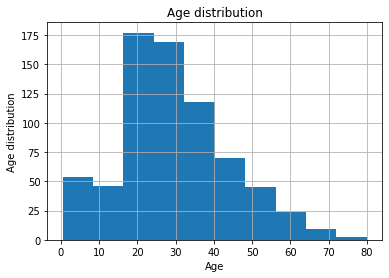

In [ ]:
df_train['Age'].hist(bins = 10)
plt.xlabel('Age')
plt.ylabel('Age distribution')
plt.title('Age distribution')
plt.show()

In [ ]:
df_train['Age_missing'] = df_train['Age'].apply(lambda x: -1 if math.isnan(x) else 0)
df_train['Age_missing'] = df_train['Age_missing'].astype('category')

median_age = df_train['Age'].median()

df_train['Age'].fillna(median_age, inplace = True)
df_train['Age'] = df_train['Age'].astype('int16')

In [ ]:
df_train['Age'] = df_train['Age'].astype('int16')

In [ ]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Age_missing      0
dtype: int64

In [ ]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,NaN,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,NaN,0


In [ ]:
df_train[df_train['Pclass'] == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.5500,C103,S,0
23,24,1,1,"Sloper, Mr. William Thompson",male,28,0,0,113788,35.5000,A6,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47,1,1,11751,52.5542,D35,S,0
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33,0,0,695,5.0000,B51 B53 B55,S,0
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56,0,1,11767,83.1583,C50,C,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,0


In [ ]:
df_train[df_train['Pclass'] == 1].groupby('Embarked')['Fare'].mean()

Embarked
C    104.718529
Q     90.000000
S     70.364862
Name: Fare, dtype: float64

In [ ]:
df_train.dropna(subset = ['Embarked'], inplace = True)

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0


In [ ]:
df_train.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     889 non-null    int8    
 1   Pclass       889 non-null    int8    
 2   Sex          889 non-null    category
 3   Age          889 non-null    int16   
 4   SibSp        889 non-null    int8    
 5   Parch        889 non-null    int8    
 6   Fare         889 non-null    float64 
 7   Embarked     889 non-null    category
 8   Age_missing  889 non-null    category
dtypes: category(3), float64(1), int16(1), int8(4)
memory usage: 22.0 KB


In [ ]:
df_train_oho = pd.get_dummies(df_train, drop_first = True)

In [ ]:
column_names = list(df_train_oho.columns)
column_names

column_names.remove('Survived')
column_names.append('Survived')
df_train_oho = df_train_oho.reindex(columns=column_names)

In [ ]:
# collect all preprocessing steps into function
def preprocess_fun(df, data_set_type = 'train'):
    df['Age_missing'] = df['Age'].apply(lambda x: -1 if math.isnan(x) else 0)
    df['Age_missing'] = df['Age_missing'].astype('category')

    median_age = df['Age'].median()

    df['Age'].fillna(median_age, inplace = True)
    df['Age'] = df['Age'].astype('int16')
    
    df.dropna(subset = ['Embarked'], inplace = True)
    
    df.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
    
    df_oho = pd.get_dummies(df, drop_first = True)
    
    
    if data_set_type == 'train':
        column_names = list(df_oho.columns)
        column_names.remove('Survived')
        column_names.append('Survived')
        df_oho = df_oho.reindex(columns=column_names)
    
    return df_oho

In [ ]:
df_train_oho.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0,Survived
0,3,22,1,0,7.2500,1,0,1,1,0
1,1,38,1,0,71.2833,0,0,0,1,1
2,3,26,0,0,7.9250,0,0,1,1,1
3,1,35,1,0,53.1000,0,0,1,1,1
4,3,35,0,0,8.0500,1,0,1,1,0


In [ ]:
df_train_oho_check = preprocess_fun(df_train_before_preprocessing)
df_train_oho_check.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0,Survived
0,3,22,1,0,7.2500,1,0,1,1,0
1,1,38,1,0,71.2833,0,0,0,1,1
2,3,26,0,0,7.9250,0,0,1,1,1
3,1,35,1,0,53.1000,0,0,1,1,1
4,3,35,0,0,8.0500,1,0,1,1,0


In [ ]:
pd.testing.assert_frame_equal(df_train_oho, df_train_oho_check)

### Test dataset

In [ ]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
df_test[df_test['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
df_test_oho = preprocess_fun(df_test, data_set_type = 'test')
df_test_oho.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0
0,3,34,0,0,7.8292,1,1,0,1
1,3,47,1,0,7.0000,0,0,1,1
2,2,62,0,0,9.6875,1,1,0,1
3,3,27,0,0,8.6625,1,0,1,1
4,3,22,1,1,12.2875,0,0,1,1


In [ ]:
df_train_oho.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0,Survived
0,3,22,1,0,7.2500,1,0,1,1,0
1,1,38,1,0,71.2833,0,0,0,1,1
2,3,26,0,0,7.9250,0,0,1,1,1
3,1,35,1,0,53.1000,0,0,1,1,1
4,3,35,0,0,8.0500,1,0,1,1,0


In [ ]:
df_test_oho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int8   
 1   Age            418 non-null    int16  
 2   SibSp          418 non-null    int8   
 3   Parch          418 non-null    int8   
 4   Fare           417 non-null    float64
 5   Sex_male       418 non-null    uint8  
 6   Embarked_Q     418 non-null    uint8  
 7   Embarked_S     418 non-null    uint8  
 8   Age_missing_0  418 non-null    uint8  
dtypes: float64(1), int16(1), int8(3), uint8(4)
memory usage: 10.2 KB


In [ ]:
features = df_train_oho.drop('Survived', axis = 1)
labels = df_train_oho['Survived']

In [ ]:
features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0
0,3,22,1,0,7.2500,1,0,1,1
1,1,38,1,0,71.2833,0,0,0,1
2,3,26,0,0,7.9250,0,0,1,1
3,1,35,1,0,53.1000,0,0,1,1
4,3,35,0,0,8.0500,1,0,1,1


In [ ]:
labels.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int8

In [ ]:
print('{:.2%} survived'.format(labels.sum()/len(labels)))

38.25% survived


In [ ]:
features_test = df_test_oho

In [ ]:
features_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_missing_0
0,3,34,0,0,7.8292,1,1,0,1
1,3,47,1,0,7.0000,0,0,1,1
2,2,62,0,0,9.6875,1,1,0,1
3,3,27,0,0,8.6625,1,0,1,1
4,3,22,1,1,12.2875,0,0,1,1


In [ ]:
len(features_test)

418

## Random Forest

### Out-of-the box Random Forest

In [ ]:
RF_base_model = RandomForestClassifier()

In [ ]:
RF_base_model.fit(features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
features_test.isna().sum()

Pclass           0
Age              0
SibSp            0
Parch            0
Fare             1
Sex_male         0
Embarked_Q       0
Embarked_S       0
Age_missing_0    0
dtype: int64

In [ ]:
features_test['Fare'].value_counts()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
           ..
9.3250      1
14.4583     1
15.0333     1
25.4667     1
21.0750     1
Name: Fare, Length: 169, dtype: int64

In [ ]:
features_test['Fare'].value_counts().index[0]

7.75

In [ ]:
features_test.loc[features_test['Fare'].isnull(), 'Fare'] = features_test['Fare'].value_counts().index[0]

In [ ]:
predictions = RF_base_model.predict(features_test)

In [ ]:
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
submission_df = pd.read_csv('https://raw.githubusercontent.com/valeman/Titanic_survival/main/gender_submission.csv', index_col = 'PassengerId')
submission_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [ ]:
submission_df['Survived'] = predictions

In [ ]:
submission_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,0


In [ ]:
submission_df.to_csv('submission_random_forest.csv')

### Random Forest - Hyperparameter optimization

In [ ]:
# evaluate the model
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123435)
n_scores = cross_val_score(model,features, labels, scoring='accuracy', cv=cv, verbose = 2, n_jobs=-1,
                        error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


Accuracy: 0.804 (0.048)


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


In [ ]:
# # based on https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 105, num = 20)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [ ]:
# %%time

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune

# rf = RandomForestClassifier()
# # Random search of parameters, using 5 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 5, 
#                                verbose=2, random_state=12345, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(features, labels)

In [ ]:
# rf_random.best_params_

In [ ]:
# fit and save the model
RF_optimized = RandomForestClassifier(n_estimators = 1783, min_samples_split = 5, min_samples_leaf = 1, \
                               max_features = 'auto', max_depth = 78, bootstrap = True)

RF_optimized.fit(features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=78, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1783,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
best_params = RF_optimized.get_params()
print(best_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 78, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1783, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
import json

with open('best_params_Random_Forest.json', 'w') as fp:
    json.dump(best_params, fp)

In [ ]:
with open('best_params_Random_Forest.json', 'r') as fp:
    best_params = json.load(fp)

In [ ]:
print(best_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 78, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1783, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


{'n_estimators': 1783,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 78,
 'bootstrap': True}

### Optimized Random Forest

In [ ]:
# # evaluate the model
# RF_optimized = RandomForestClassifier(n_estimators = 1783, min_samples_split = 5, min_samples_leaf = 1, \
#                                max_features = 'auto', max_depth = 78, bootstrap = True)

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123435)
# n_scores = cross_val_score(RF_optimized,features, labels, scoring='accuracy', cv=cv, verbose = 2, n_jobs=-1,
#                         error_score='raise')
# # report performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# RF_optimized.fit(features, labels)

In [ ]:
# predictions = RF_optimized.predict(features_test)

In [ ]:
# submission_df['Survived'] = predictions

In [ ]:
# submission_df.head()

In [ ]:
# submission_df.to_csv('submission_optimized_random_forest.csv')

## LightAutoML (baseline)

In [ ]:
from sklearn.metrics import f1_score
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [ ]:
%timeit
automl = TabularAutoML(task = Task('binary', metric = lambda y_true, y_pred: f1_score(y_true, (y_pred > 0.5)*1)))
oof_pred = automl.fit_predict(data_train,  roles = {'target': 'Survived', 'drop': ['PassengerId']})
test_pred = automl.predict(data_test)

pd.DataFrame({'PassengerId':data_test.PassengerId, 'Survived': (test_pred.data[:, 0] > 0.5)*1}).to_csv('LightAutoMLsubmit.csv', index = False)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning:

All-NaN slice encountered



## LightAutoML (improved performance - extra features added)

### Step 0.1. Import necessary libraries

In [ ]:
# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
#from lightautoml.utils.profiler import Profiler

### Step 0.2. Parameters

In [ ]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 600 # Time in seconds for automl run

### Step 0.3. Fix torch number of threads and numpy seed

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### Step 0.5. Add new features

In [ ]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def create_extra_features(data):
    data['Ticket_type'] = data['Ticket'].map(lambda x: x[0:3])
    data['Name_Words_Count'] = data['Name'].map(lambda x: len(x.split()))
    data['Has_Cabin'] = data["Cabin"].map(lambda x: 1 - int(type(x) == float))
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['CategoricalFare'] = pd.qcut(data['Fare'], 5).astype(str)
    data['CategoricalAge'] = pd.cut(data['Age'], 5).astype(str)
    
    data['Title'] = data['Name'].apply(get_title).replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}).fillna(0)
    return data

In [ ]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data = create_extra_features(data_train)
test_data = create_extra_features(data_test)

### Step 0.6. Data splitting for train-test

In [ ]:
%%time

tr_data, valid_data = train_test_split(train_data, test_size=0.2,
                                       stratify=train_data[['Survived']], 
                                       random_state=42)

#logging.info(‘Parts sizes: tr_data = {}, valid_data = {}’
#              .format(tr_data.shape, valid_data.shape))

CPU times: user 10.6 ms, sys: 25 µs, total: 10.6 ms
Wall time: 9.56 ms


### ========= LightAutoML preset usage =========

#### Step 1. Create Task

In [ ]:
%%time
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

CPU times: user 3.76 ms, sys: 961 µs, total: 4.72 ms
Wall time: 4.69 ms


In [ ]:
# As we have a binary classification competition, we setup Task object with ‘binary’ value with
# F1 metric to pay more attention for model predictions precision-recall balance

def f1_metric(y_true, y_pred):
    return f1_score(y_true, (y_pred > 0.5).astype(int))

task = Task('binary', metric = f1_metric)

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Name_Words_Count,Has_Cabin,FamilySize,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,4,0,2,"(-0.001, 7.854]","(16.336, 32.252]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,7,1,2,"(39.688, 512.329]","(32.252, 48.168]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STO,3,0,1,"(7.854, 10.5]","(16.336, 32.252]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113,7,1,2,"(39.688, 512.329]","(32.252, 48.168]",3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373,4,0,1,"(7.854, 10.5]","(32.252, 48.168]",1


#### Step 2. Setup columns' roles

In [ ]:
%%time

roles = {'target': 'Survived',
         'drop': ['PassengerId', 'Name', 'Ticket']}

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [ ]:
automl = TabularAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})

Base algorithms, which are currently available to be in general_params use_algos :
* Linear model (called 'linear_l2')
* LightGBM model with expert params based on dataset ('lgb')
* LightGBM with tuned params using Optuna ('lgb_tuned')
* CatBoost model with expert params ('cb') and
* CatBoost with params from Optuna ('cb_tuned')

To fit our TabularAutoML preset model on the train part of the dataset, we use the code below:

#### Step 3. Create AutoML model from preset

In [ ]:
oof_pred = automl.fit_predict(tr_data, roles = roles)

#### Step 4. Predict to validation data and check scores

In [ ]:
valid_pred = automl.predict(valid_data)

And as we have the ground truth labels for this object let’s check how good we are

In [ ]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int))
print('OOF acc: {}'.format(acc_score(tr_data['Survived'].values,      oof_pred.data[:, 0])))
print('VAL acc: {}'.format(acc_score(valid_data['Survived'].values, valid_pred.data[:, 0])))

OOF acc: 0.8342696629213483
VAL acc: 0.8100558659217877


#### Step 5. Create LightAutoML model with time utilization

In [ ]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})

In [ ]:
oof_pred = automl.fit_predict(tr_data, roles = roles)

#### Step 6. Predict to validation data and check scores for utilized model

In [ ]:
print('OOF acc: {}'.format(acc_score(tr_data['Survived'].values,      oof_pred.data[:, 0])))
print('VAL acc: {}'.format(acc_score(valid_data['Survived'].values, valid_pred.data[:, 0])))

OOF acc: 0.875
VAL acc: 0.8100558659217877


#### Step 7. Retrain selected model on the full dataset and predict for the real test

In [ ]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned']]})
oof_pred = automl.fit_predict(train_data, roles = roles)
test_pred = automl.predict(test_data)

#### Step 8. Prepare submission for Kaggle

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Name_Words_Count,Has_Cabin,FamilySize,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,4,0,2,"(-0.001, 7.854]","(16.336, 32.252]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,7,1,2,"(39.688, 512.329]","(32.252, 48.168]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STO,3,0,1,"(7.854, 10.5]","(16.336, 32.252]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113,7,1,2,"(39.688, 512.329]","(32.252, 48.168]",3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373,4,0,1,"(7.854, 10.5]","(32.252, 48.168]",1


In [ ]:
submission_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,0


In [ ]:
submission_df['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)

In [ ]:
submission_df.to_csv('automl_utilized_600_f1_score.csv')